### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from time import time
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import *

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, multilabel_confusion_matrix
from tensorflow.keras.applications import * #Efficient Net included here

### Helper functions

In [3]:
def print_loss_history(training_history, logscale=False):
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, color='red', label='Training loss')
    plt.plot(epochs, val_loss, color='green', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if logscale:
        plt.yscale('log')
    plt.show()
    return

def print_accuracy_history(training_history, logscale=False):
    # acc = training_history['categorical_accuracy']
    # val_acc = training_history['val_categorical_accuracy']
    acc = training_history['accuracy']
    val_acc = training_history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, color='red', label='Training acc')
    plt.plot(epochs, val_acc, color='green', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    if logscale:
      plt.yscale('log')
    plt.show()
    return

In [4]:
# calculate a 6-number summary
from numpy import percentile
from numpy.random import rand

def six_number_summary(data):
  data = data
  # calculate quartiles
  quartiles = percentile(data, [25, 50, 75])
  # calculate min/max
  data_min, data_max, data_avg = np.min(data), np.max(data), np.average(data)
  # print 6-number summary
  return 'Avg: %.3f' % data_avg, 'Min: %.3f' % data_min, 'Q1: %.3f' % quartiles[0],'Median: %.3f' % quartiles[1], 'Q3: %.3f' % quartiles[2],'Max: %.3f' % data_max

  # print('Min: %.3f' % data_min)
  # print('Q1: %.3f' % quartiles[0])
  # print('Median: %.3f' % quartiles[1])
  # print('Q3: %.3f' % quartiles[2])
  # print('Max: %.3f' % data_max)

### Constants

In [5]:
SIZE = 1000
INTEREST_RATE = .1
TIME_TO_EXP = .25
STDEV = .5

### Create input data for Black-Scholes

In [6]:
stock_price = np.round(np.random.uniform(low=100.0, high=150.0, size=SIZE), 2)
print(len(stock_price))
print(stock_price[0:5])

1000
[102.5  137.74 130.55 131.77 107.64]


In [7]:
exercise_price = np.round(np.random.uniform(low=80.0, high=100.0, size=SIZE), 2)
print(len(exercise_price))
print(exercise_price[0:5])

1000
[88.68 86.9  98.08 85.26 89.59]


In [8]:
interest_rate = np.full(SIZE, INTEREST_RATE)
print(len(interest_rate))
print(interest_rate[0:5])

1000
[0.1 0.1 0.1 0.1 0.1]


In [9]:
time_to_expiration = np.full(SIZE, TIME_TO_EXP)
print(len(time_to_expiration))
print(time_to_expiration[0:5])

1000
[0.25 0.25 0.25 0.25 0.25]


In [10]:
standard_deviation = np.full(SIZE, STDEV)
print(len(standard_deviation))
print(standard_deviation[0:5])

1000
[0.5 0.5 0.5 0.5 0.5]


### Create initial dataframe

In [11]:
input_dict = {'stock_price': stock_price, 
     'exercise_price': exercise_price, 
     'interest_rate': interest_rate,
     'time_to_exp': time_to_expiration,
     'stdev': standard_deviation 
     }

In [12]:
df = pd.DataFrame(data=input_dict)

In [13]:
print(df.shape)

(1000, 5)


In [14]:
df.head()

,stock_price,exercise_price,interest_rate,time_to_exp,stdev
0,102.50,88.68,0.1,0.25,0.5
1,137.74,86.90,0.1,0.25,0.5
2,130.55,98.08,0.1,0.25,0.5
3,131.77,85.26,0.1,0.25,0.5
4,107.64,89.59,0.1,0.25,0.5


### Define functions for Black-Scholes outputs

I created these functions from scratch referencing the text "Investments" by Bodie, Kane, and Marcus

In [15]:
# Define N(d1) function
# sp=stock price, ep=exercise price, ir=interest rate, t=time to exp , stdev=standard deviation
def Nd1(sp, ep, ir, t, stdev):
  d1 = np.round(((math.log(sp/ep) + (ir + ((stdev**2)/2)) * t) / (stdev * math.sqrt(t))), 2)
  N_d1 = np.round(norm.cdf(d1), 4)
  return N_d1

In [16]:
# Define N(d2) function
# sp=stock price, ep=exercise price, ir=interest rate, t=time to exp , stdev=standard deviation
def Nd2(sp, ep, ir, t, stdev):
  d1 = np.round(((math.log(sp/ep) + (ir + ((stdev**2)/2)) * t) / (stdev * math.sqrt(t))), 2)
  d2 = np.round(d1 - (stdev * math.sqrt(t)), 2)
  N_d2 = np.round(norm.cdf(d2), 4)
  return N_d2

In [17]:
# Tests of N(d) functions; they are indeed producing the expected output!
print(Nd1(100, 95, .1, .25, .5))
print(Nd2(100, 95, .1, .25, .5))

0.6664
0.5714


In [18]:
# Define the Black-Scholes pricing formula for a call option; returns current call option value
def C(sp, ep, ir, t, stdev):
  d1 = np.round(((math.log(sp/ep) + (ir + ((stdev**2)/2)) * t) / (stdev * math.sqrt(t))), 2)
  d2 = np.round(d1 - (stdev * math.sqrt(t)), 2)
  N_d1 = np.round(norm.cdf(d1), 4)
  N_d2 = np.round(norm.cdf(d2), 4)
  call_value = np.round((sp * N_d1) - (ep * (math.e**(-1.0*ir*t)) * N_d2), 2)
  return call_value

In [19]:
# Tests of C function; it is indeed producing the expected output!
C(100, 95, .1, .25, .5)

13.7

In [20]:
# Notes:
# cdf is the probability that the random variable value is less than or equal to x
# https://www.graduatetutor.com/statistics-tutor/probability-density-function-pdf-and-cumulative-distribution-function-cdf/

### Add call values to the dataframe

In [21]:
df.columns

Index(['stock_price', 'exercise_price', 'interest_rate', 'time_to_exp',
       'stdev'],
      dtype='object')

In [22]:
# COMMENTED OUT - ONLY NEED TO RUN ONCE
# # Create new column in dataframe for call option value
df['call_value'] = df.apply(lambda x: C(x['stock_price'], 
                x['exercise_price'],
                x['interest_rate'],
                x['time_to_exp'],
                x['stdev']), axis=1)

In [23]:
#df.rename(columns={'C': 'call_value'}, inplace=True)

In [24]:
df.shape

(1000, 6)

In [25]:
df.head()

,stock_price,exercise_price,interest_rate,time_to_exp,stdev,call_value
0,102.50,88.68,0.1,0.25,0.5,19.48
1,137.74,86.90,0.1,0.25,0.5,53.26
2,130.55,98.08,0.1,0.25,0.5,36.33
3,131.77,85.26,0.1,0.25,0.5,48.95
4,107.64,89.59,0.1,0.25,0.5,23.00


In [26]:
# Testing to see if the lambda function output matches the C function created earlier
C(109.79, 81.79, 0.1, 0.25, 0.5)

31.13

### Normalize

In [27]:
df.columns

Index(['stock_price', 'exercise_price', 'interest_rate', 'time_to_exp',
       'stdev', 'call_value'],
      dtype='object')

In [28]:
df.columns[0:2]

Index(['stock_price', 'exercise_price'], dtype='object')

In [29]:
df.head()

,stock_price,exercise_price,interest_rate,time_to_exp,stdev,call_value
0,102.50,88.68,0.1,0.25,0.5,19.48
1,137.74,86.90,0.1,0.25,0.5,53.26
2,130.55,98.08,0.1,0.25,0.5,36.33
3,131.77,85.26,0.1,0.25,0.5,48.95
4,107.64,89.59,0.1,0.25,0.5,23.00


In [30]:
x = df.values[:, 0:2] #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_spep_normalized = pd.DataFrame(x_scaled, columns=df.columns[0:2])
df_spep_normalized.head()

,stock_price,exercise_price
0,0.048688,0.433650
1,0.754759,0.344517
2,0.610699,0.904357
3,0.635143,0.262394
4,0.151673,0.479219


In [31]:
cols = df.columns[2:6]
df_cols = df[cols]
df_cols.head() 

,interest_rate,time_to_exp,stdev,call_value
0,0.1,0.25,0.5,19.48
1,0.1,0.25,0.5,53.26
2,0.1,0.25,0.5,36.33
3,0.1,0.25,0.5,48.95
4,0.1,0.25,0.5,23.00


In [32]:
df2 = df_spep_normalized.join(df_cols)

In [33]:
df2.head()

,stock_price,exercise_price,interest_rate,time_to_exp,stdev,call_value
0,0.048688,0.433650,0.1,0.25,0.5,19.48
1,0.754759,0.344517,0.1,0.25,0.5,53.26
2,0.610699,0.904357,0.1,0.25,0.5,36.33
3,0.635143,0.262394,0.1,0.25,0.5,48.95
4,0.151673,0.479219,0.1,0.25,0.5,23.00


In [34]:
# Notes
# https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
# Mean normalization
#normalized_df=(df-df.mean())/df.std() 
# Min-max normalization
#normalized_df=(df-df.min())/(df.max()-df.min())

### Train/test/val split

In [35]:
X = df2[['stock_price', 'exercise_price', 'interest_rate', 'time_to_exp', 'stdev']]

In [36]:
X.head()

,stock_price,exercise_price,interest_rate,time_to_exp,stdev
0,0.048688,0.433650,0.1,0.25,0.5
1,0.754759,0.344517,0.1,0.25,0.5
2,0.610699,0.904357,0.1,0.25,0.5
3,0.635143,0.262394,0.1,0.25,0.5
4,0.151673,0.479219,0.1,0.25,0.5


In [37]:
y = df2[['call_value']]

In [38]:
y.head()

,call_value
0,19.48
1,53.26
2,36.33
3,48.95
4,23.00


In [39]:
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, train_size=0.8)

In [40]:
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5)

In [41]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(800, 5) (800, 1)
(100, 5) (100, 1)
(100, 5) (100, 1)


### Reshaping to work with Keras models

In [42]:
X_train_nparray, y_train_nparray = X_train.to_numpy(), y_train.to_numpy()

In [43]:
X_train_2 = np.reshape(X_train_nparray, (X_train_nparray.shape[0], X_train_nparray.shape[1], 1))
X_train_2.shape

(800, 5, 1)

In [44]:
X_test_nparray, y_test_nparray = X_test.to_numpy(), y_test.to_numpy()

In [45]:
X_test_2 = np.reshape(X_test_nparray, (X_test_nparray.shape[0], X_test_nparray.shape[1], 1))
X_test_2.shape

(100, 5, 1)

In [46]:
X_val_nparray, y_val_nparray = X_val.to_numpy(), y_val.to_numpy()

In [47]:
X_val_2 = np.reshape(X_val_nparray, (X_val_nparray.shape[0], X_val_nparray.shape[1], 1))
X_val_2.shape

(100, 5, 1)

In [48]:
Xtrain = X_train_2
Xval = X_val_2
ytrain = y_train_nparray

In [49]:
print(Xtrain.shape)
print(Xval.shape)
print(ytrain.shape)

(800, 5, 1)
(100, 5, 1)
(800, 1)


### Neural network model

In [ ]:
# 5 neurons representing 5 features; 1 output layer to predict call option value
model = Sequential()
model.add(Dense(5,activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(1))

In [ ]:
initial_learning_rate=1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000, 
    decay_rate=0.96,
    staircase=True
)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mean_squared_error')

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size = 2,
    epochs = 500,
    verbose=1
)

Epoch 1/500
400/400 [==============================] - 1s 2ms/step - loss: 0.0365 - val_loss: 0.0350
Epoch 2/500
400/400 [==============================] - 1s 2ms/step - loss: 0.0364 - val_loss: 0.0367
Epoch 3/500
400/400 [==============================] - 1s 2ms/step - loss: 0.0352 - val_loss: 0.0347
Epoch 4/500
400/400 [==============================] - 1s 2ms/step - loss: 0.0355 - val_loss: 0.0356
Epoch 5/500
400/400 [==============================] - 1s 2ms/step - loss: 0.0356 - val_loss: 0.0362
Epoch 6/500
400/400 [==============================] - 1s 2ms/step - loss: 0.0364 - val_loss: 0.0414
Epoch 7/500
400/400 [==============================] - 1s 2ms/step - loss: 0.0356 - val_loss: 0.0356
Epoch 8/500
400/400 [==============================] - 1s 2ms/step - loss: 0.0359 - val_loss: 0.0367
Epoch 9/500
400/400 [==============================] - 1s 2ms/step - loss: 0.0360 - val_loss: 0.0356
Epoch 10/500
400/400 [==============================] - 1s 2ms/step - loss: 0.0355 - val_lo

In [ ]:
#model.history.history.keys()

dict_keys(['loss', 'val_loss'])

Loss value is well below 1.0; validation loss is very volatile

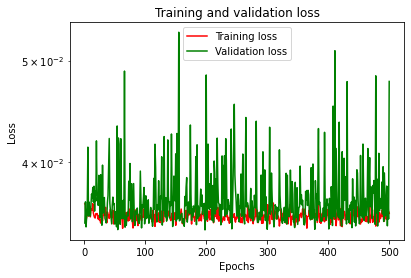

In [ ]:
print_loss_history(history.history, logscale=True)

In [ ]:
print(f"The six number summary for training loss is:\n {six_number_summary(history.history['loss'])}")
print(f"The six number summary for validation loss is:\n {six_number_summary(history.history['val_loss'])}")

The six number summary for training loss is:
 ('Avg: 0.036', 'Min: 0.035', 'Q1: 0.035', 'Median: 0.036', 'Q3: 0.036', 'Max: 0.037')
The six number summary for validation loss is:
 ('Avg: 0.037', 'Min: 0.034', 'Q1: 0.035', 'Median: 0.036', 'Q3: 0.037', 'Max: 0.053')


### Inference

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred[0:5]

array([[20.834759],
       [42.50136 ],
       [34.002964],
       [18.686829],
       [61.6536  ]], dtype=float32)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:', metrics.explained_variance_score(y_test,y_pred))

MAE: 0.1805972881317137
MSE: 0.040225011404424825
RMSE: 0.2005617396325252
VarScore: 0.9998436758265724


This looks too good to be true...

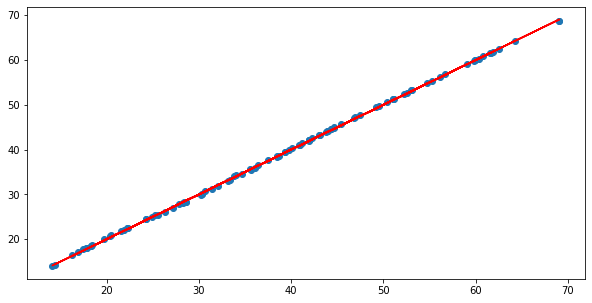

In [ ]:
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test, y_pred)
# Perfect predictions
plt.plot(y_test,y_test,'r')

### APPENDIX

### Binary option model

I got close to getting this binary option model to work, but there was an error in the eu.price() method that I could not fix

In [128]:
option_eu = euro_option(
    217.58,
    215,
    0.05,
    0.1,
    40,
    #{"tk": "AAPL", "is_cal": True, "start": "2020-01-01", "end": "2021-01-01"}
    {"tk": "AAPL", "is_cal": True, "start": "2017-08-18", "end": "2018-08-18"}
)

print(option_eu.price())

[*********************100%***********************]  1 of 1 completed


ZeroDivisionError: ignored

In [ ]:
!pip install arch

In [ ]:
!pip install yfinance

In [97]:
from __future__ import division

In [82]:
import pandas
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

[*********************100%***********************]  1 of 1 completed
Date
2016-01-05   -0.025379
2016-01-06   -0.019764
2016-01-07   -0.043121
2016-01-08    0.005274
2016-01-11    0.016062
2016-01-12    0.014409
2016-01-13   -0.026047
2016-01-14    0.021635
2016-01-15   -0.024308
2016-01-19   -0.004851
2016-01-20    0.001344
2016-01-21   -0.005075
2016-01-22    0.051802
2016-01-25   -0.019716
2016-01-26    0.005516
2016-01-27   -0.067965
2016-01-28    0.007146
2016-01-29    0.033958
2016-02-01   -0.009393
2016-02-02   -0.020429
2016-02-03    0.019599
2016-02-04    0.008003
2016-02-05   -0.027071
2016-02-08    0.010475
2016-02-09   -0.000211
2016-02-10   -0.007609
2016-02-11   -0.006065
2016-02-12    0.003090
2016-02-16    0.027804
2016-02-17    0.015199
2016-02-18   -0.019138
2016-02-19   -0.002288
2016-02-22    0.008708
2016-02-23   -0.022865
2016-02-24    0.014781
2016-02-25    0.006844
2016-02-26    0.001549
2016-02-29   -0.002273
Name: log, dtype: float64


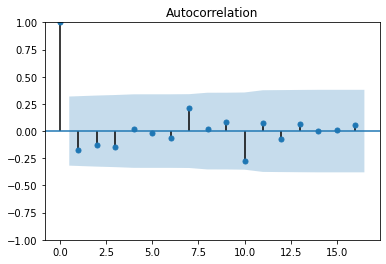

In [83]:
# import pandas_datareader.data as pdr
# import fix_yahoo_finance as yf
import arch
from statsmodels.graphics.tsaplots import plot_acf
# yf.pdr_override()

class stock_vol:

	def __init__(self, tk, start, end):
		self.tk = tk
		self.start = start
		self.end = end
		all_data = pdr.get_data_yahoo(self.tk, start=self.start, end=self.end)
		self.stock_data = pd.DataFrame(all_data['Adj Close'], columns=["Adj Close"])
		self.stock_data["log"] = np.log(self.stock_data)-np.log(self.stock_data.shift(1))

	def mean_sigma(self):
		st = self.stock_data["log"].dropna().ewm(span=252).std()
		sigma = st.iloc[-1]
		return sigma

	def garch_sigma(self):
		model = arch.arch_model(self.stock_data["log"].dropna(), mean='Zero', vol='GARCH', p=1, q=1)
		model_fit = model.fit()
		forecast = model_fit.forecast(horizon=1)
		var = forecast.variance.iloc[-1]
		sigma = float(np.sqrt(var))
		return sigma


if __name__ == "__main__":
	vol = stock_vol("AAPL", start="2016-01-01", end="2016-03-01")
	test = vol.stock_data["log"].dropna()
	print(test)
	fig = plot_acf(test)
	plt.show()

In [122]:
class stockoption():

	def __init__(self, S0, K, r, T, N, prm):
		"""
		Initialise parameters
		:param S0: initial stock price
		:param K: strike price
		:param r: risk free interest rate per year
		:param T: length of option in years
		:param N: number of binomial iterations
		:param prm: dictionary with additional parameters
		"""
		self.S0 = S0
		self.K = K
		self.r = r
		self.T = T
		self.N = N
		"""
		prm parameters:
		start = date from when you want to analyse stocks, "yyyy-mm-dd"
		end = date of final stock analysis (likely current date), "yyyy-mm-dd"
		tk = ticker label
		div = dividend paid
		is_calc = is volatility calculated using stock price history, boolean
		use_garch = use GARCH model, boolean
		sigma = volatility of stock
		is_call = is it a call option, boolean
		eu_option = European or American option, boolean
		"""
		self.tk = prm.get('tk', None)
		self.start = prm.get('start', None)
		self.end = prm.get('end', None)
		self.div = prm.get('div', 0)
		self.is_calc = prm.get('is_calc', False)
		self.use_garch = prm.get('use_garch', False)
		self.vol = stock_vol(self.tk, self.start, self.end)
		if self.is_calc:
			if self.use_garch:
				self.sigma = self.vol.garch_sigma()
			else:
				self.sigma = self.vol.mean_sigma()
		else:
			self.sigma = prm.get('sigma', 0)
		self.is_call = prm.get('is_call', True)
		self.eu_option = prm.get('eu_option', True)
		'''
		derived values:
		dt = time per step, in years
		df = discount factor
		'''
		self.dt = float(T)/float(N)
		self.df = float(math.exp(-(r-self.div)*self.dt))

In [127]:
class euro_option(stockoption):
	'''
	calculate required preliminary parameters:
	u = factor change of upstate
	d = factor change of downstate
	qu = risk free upstate probability
	qd = risk free downstate probability
	M = number of nodes
	'''
	def __int_prms__(self):
		self.M = float(self.N + 1) 
		self.u = float(math.exp(self.sigma*math.sqrt(self.dt)))
		self.d = float(1./self.u)
		self.qu = float(math.exp((self.r-self.div)*self.dt)-self.d)/float(self.u-self.d)
		self.qd = float(1-self.qu)
		
	def stocktree(self):
		stocktree = np.zeros([self.M, self.M])
		for i in range(self.M):
			for j in range(self.M):
				stocktree[j, i] = self.S0*(self.u**(i-j))*(self.d**j)
		return stocktree

	def option_price(self, stocktree):
		option = np.zeros([self.M, self.M])
		if self.is_call:
			option[:, self.M-1] = np.maximum(np.zeros(self.M), (stocktree[:, self.N] - self.K))
		else:
			option[:, self.M-1] = np.maximum(np.zeros(self.M), (self.K - stocktree[:, self.N]))
		return option

	def optpricetree(self, option):
		for i in np.arange(self.M-2, -1, -1):
			for j in range(0, i+1):
				option[j, i] = math.exp(-self.r*self.dt) * (self.qu*option[j, i+1]+self.qd*option[j+1, i+1])
		return option

	def begin_tree(self):
		stocktree = self.stocktree()
		payoff = self.option_price(stocktree)
		return self.optpricetree(payoff)

	def price(self):
		self.__int_prms__()
		self.stocktree()
		payoff = self.begin_tree()
		return payoff[0, 0]

In [ ]:
# Source:
# https://github.com/VivekPa/BinomialOptModel/blob/master/eu_option.py

### Monte Carlo

Researched various Monte Carlo methods; Did not seem to be flexible enough for me to use with different inputs

In [ ]:
number_of_simulations = 10000
amount_underlying = 100
mu = 0.06 

#S0 = 15 #sp? stock price?
strike = 1.1 #ep
sigma = 0.2 #stdev
r = 0.015 #ir

def payoff(x):
    return amount_underlying * np.maximum(0, x-strike)

num0 = np.random.normal(0, 1, number_of_simulations)

S1 = np.exp(r-sigma**2/2+sigma*num0)

C0 = math.exp(-r)*np.mean(payoff(S1))

print(C0)

4.914759206784416


In [ ]:
class European_Call_Payoff:

    def __init__(self, strike):
        self.strike = strike

    def get_payoff(self, stock_price):
        if stock_price > self.strike:
            return stock_price - self.strike
        else:
            return 0


class GeometricBrownianMotion:

    def simulate_paths(self):
        while(self.T - self.dt > 0):
            dWt = np.random.normal(0, math.sqrt(self.dt))  # Brownian motion
            dYt = self.drift*self.dt + self.volatility*dWt  # Change in price
            self.current_price += dYt  # Add the change to the current price
            self.prices.append(self.current_price)  # Append new price to series
            self.T -= self.dt  # Accound for the step in time

    def __init__(self, initial_price, drift, volatility, dt, T):
        self.current_price = initial_price
        self.initial_price = initial_price
        self.drift = drift
        self.volatility = volatility
        self.dt = dt
        self.T = T
        self.prices = []
        self.simulate_paths()

# Model Parameters
paths = 100
initial_price = 100
drift = .08
volatility = .3
dt = 1/365
T = 1

price_paths = []

# Generate a set of sample paths
for i in range(0, paths):
    price_paths.append(GeometricBrownianMotion(initial_price, drift, volatility, dt, T).prices)

call_payoffs = []
ec = European_Call_Payoff(100)
risk_free_rate = .01
for price_path in price_paths:
    call_payoffs.append(ec.get_payoff(price_path[-1])/(1 + risk_free_rate))  # We get the last stock price in the series generated by GBM to determin the payoff and discount it by one year

# # Plot the set of generated sample paths
# for price_path in price_paths:
#     plt.plot(price_path)
# plt.show()

print(np.average(call_payoffs)*100)  # Options are in blocks of 100


20.352184064835228


In [ ]:
# Source:
# https://towardsdatascience.com/monte-carlo-pricing-in-python-eafc29e3b6c9

In [ ]:
# Notes:
# https://en.wikipedia.org/wiki/Monte_Carlo_methods_for_option_pricing
# Since the underlying random process is the same, for enough price paths, 
# the value of a european option here should be the same as under Black–Scholes.

### LSTM model

In [112]:
# Define the LSTM model
LSTM_model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 5, return_sequences = True, input_shape = (Xtrain.shape[1], 1)))
LSTM_model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 5, return_sequences = True))
LSTM_model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 5, return_sequences = True))
LSTM_model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 5))
LSTM_model.add(Dropout(0.2))
# Adding the output layer
LSTM_model.add(Dense(units = 1))

In [113]:
initial_learning_rate=1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000, 
    decay_rate=0.96,
    staircase=True
)

In [115]:
LSTM_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss = 'mean_squared_error')

In [116]:
# Fitting to the training set
LSTM_history = LSTM_model.fit(Xtrain, 
                    ytrain, 
                    epochs = 100, 
                    batch_size = 2,
                    validation_data= (X_val, y_val),
                    validation_batch_size = 1,
                    validation_freq=1,
                    verbose=1)

Epoch 1/100
400/400 [==============================] - 12s 14ms/step - loss: 1469.7108 - val_loss: 1123.8979
Epoch 2/100
400/400 [==============================] - 4s 9ms/step - loss: 1227.1025 - val_loss: 984.7771
Epoch 3/100
400/400 [==============================] - 4s 9ms/step - loss: 1085.5177 - val_loss: 869.1888
Epoch 4/100
400/400 [==============================] - 4s 10ms/step - loss: 964.6554 - val_loss: 768.0302
Epoch 5/100
400/400 [==============================] - 4s 9ms/step - loss: 867.3727 - val_loss: 679.6829
Epoch 6/100
400/400 [==============================] - 4s 10ms/step - loss: 770.4781 - val_loss: 601.2268
Epoch 7/100
400/400 [==============================] - 4s 9ms/step - loss: 683.0704 - val_loss: 532.1951
Epoch 8/100
400/400 [==============================] - 4s 10ms/step - loss: 627.4775 - val_loss: 473.0783
Epoch 9/100
400/400 [==============================] - 4s 9ms/step - loss: 551.1757 - val_loss: 420.6734
Epoch 10/100
400/400 [========================

In [129]:
LSTM_history.history.keys()

dict_keys(['loss', 'val_loss'])

Loss is going down which is good; it might go down further with more training epochs

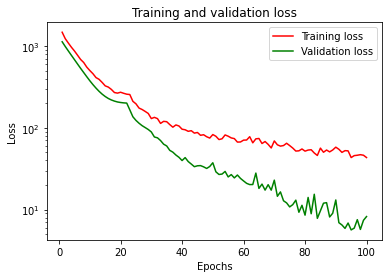

In [130]:
print_loss_history(LSTM_history.history, logscale=True)

In [131]:
print(f"The six number summary for training loss is:\n {six_number_summary(LSTM_history.history['loss'])}")
print(f"The six number summary for validation loss is:\n {six_number_summary(LSTM_history.history['val_loss'])}")

The six number summary for training loss is:
 ('Avg: 190.529', 'Min: 43.260', 'Q1: 57.634', 'Median: 78.829', 'Q3: 179.668', 'Max: 1469.711')
The six number summary for validation loss is:
 ('Avg: 123.486', 'Min: 5.651', 'Q1: 13.106', 'Median: 30.568', 'Q3: 116.007', 'Max: 1123.898')


### LSTM - Inference

In [132]:
predictions = LSTM_model.predict(X_test_2)

In [134]:
len(predictions)

100

In [133]:
predictions[0:5]

array([[29.758482],
       [58.63886 ],
       [48.393574],
       [17.748102],
       [17.21482 ]], dtype=float32)

In [144]:
y_true = y_test_nparray
y_pred_lstm = predictions 

In [145]:
print('MAE:', metrics.mean_absolute_error(y_true, y_pred_lstm))  
print('MSE:', metrics.mean_squared_error(y_true, y_pred_lstm))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_true, y_pred_lstm)))
print('VarScore:', metrics.explained_variance_score(y_true, y_pred_lstm))

MAE: 2.170628662872314
MSE: 6.905364670659484
RMSE: 2.627806056515489
VarScore: 0.9836784892592567


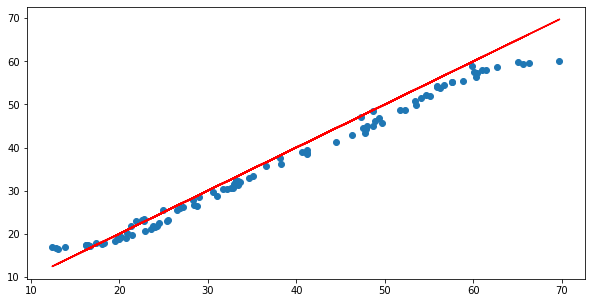

In [146]:
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_true, y_pred_lstm)
# Perfect predictions
plt.plot(y_true, y_true,'r')

### Miscellaneous

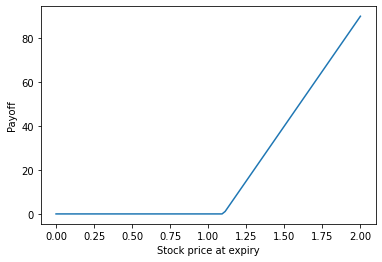

In [ ]:
# Example: European call option payoff; 100 shares, $1.1 strike price
k = 1.1
def payoff(x):
    return 100*np.maximum(0,x-k)
x=np.linspace(0, 2, 100)
y=payoff(x)
plt.plot(x,y)
plt.xlabel('Stock price at expiry')
plt.ylabel('Payoff')
plt.show()

In [ ]:
import numpy as np
import math
Nsim = 10000
amount_underlying = 100
strike = 1.1
sigma = 0.2
mu = 0.06
r = 0.015
def payoff(x):
    return amount_underlying * np.maximum(0, x-strike)
num0 = np.random.normal(0,1,Nsim)
S0 = 15
S1 = np.exp(r-sigma**2/2+sigma*num0)
C0 = math.exp(-r)*np.mean(payoff(S1))
print(C0)

4.633914478710289


In [ ]:
import numpy as np
from scipy.stats import norm
amount_underlying = 100
strike = 1.1
sigma = 0.2
mu = 0.06
r = 0.015
S0 = 1
t = 1
def fun_d1(sigma,k,t,r,x):
    return (np.log(x/k) + (r+sigma**2/2)*t)/(sigma*np.sqrt(t))
def fun_d2(sigma,k,t,r,x):
    return fun_d1(sigma,k,t,r,x) - sigma*np.sqrt(t)
def call_value(amount_underlying, sigma,k,t,r,x):
    d1 = fun_d1(sigma,k,t,r,x)
    d2 = fun_d2(sigma,k,t,r,x)
    temp = norm.cdf(d1)*x-norm.cdf(d2)*k*np.exp(-r*t)
    return amount_underlying * temp
   
C0 = call_value(amount_underlying, sigma,strike,t,r,S0)
print(C0)

4.775025500484964


In [ ]:
!pip install beautifulsoup4